In [1]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- CONFIGURATION: DEFINE THE PARAMETERS
-- 
-- 
-- 
----------------------------------------------------------------------

In [2]:
params = {
        subdirectory = 'outputs',   -- subdirectory to save experiments in
        seed = 1,                   -- initial random seed
        threads = 2,                -- threads
        model =  'conv-psd',        -- auto-encoder class: linear | linear-psd | conv | conv-psd
        inputsize = 25,             -- size of each input patch
        nfiltersin = 1,             -- number of input convolutional filters
        nfiltersout = 16,           -- number of output convolutional filters
        lambda = 1,                 -- sparsity coefficient
        beta = 1,                   -- prediction error coefficient
        eta = 0.002,                -- learning rate
        batchsize = 1,              -- batch size
        etadecay = 0.00001,         -- learning rate decay
        momentum = 0,               -- gradient momentum
        maxiter = 1000000,          -- max number of updates
        tied = 0,                   -- decoder weights are tied to encoder\s weights 
        hessian = 0,                -- compute diagonal hessian coefficients to condition learning rates
        hessiansamples = 500,       -- number of samples to use to estimate hessian
        hessianinterval = 10000,    -- compute diagonal hessian coefs at every this many samples
        minhessian = 0.02,          -- min hessian to avoid extreme speed up
        maxhessian = 500,           -- max hessian to avoid extreme slow down
        kernelsize = 9,             -- size of convolutional kernels
        statinterval = 5000,        -- interval for saving stats and models
        v = 0,                      -- be verbose
        display = 1,                -- display stuff
        wcar =  '',                 -- additional flag to differentiate this run
        datafile =  'http://torch7.s3-website-us-east-1.amazonaws.com/data/tr-berkeley-N5K-M56x56-lcn.ascii' -- Dataset URL
}

In [3]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 1: MODELS & LOSS FUNCTIONS
-- 
-- 
-- 
----------------------------------------------------------------------

In [4]:
----------------------------------------------------------------------
-- This script shows how to train autoencoders on natural images,
-- using the unsup package.
--
-- A lote of this code was written and contributed by Koray Kavukcuoglu.
--
-- In this script, we demonstrate the use of different types of
-- autoencoders. Learned filters can be visualized by providing the
-- flag -display.
--
-- Note: simple auto-encoders (with no sparsity constraint on the code) typically
-- don't yield filters that are visually appealing, although they might be
-- minimizing the reconstruction error correctly.
--
-- We demonstrate 2 types of auto-encoders:
--   * plain: regular auto-encoder
--   * predictive sparse decomposition (PSD): the encoder is trained
--     to predict an optimal sparse decomposition of the input
--
-- Both types of auto-encoders can use linear or convolutional
-- encoders/decoders. The convolutional version typically yields more
-- interesting, less redundant filters for images.
--
-- Koray Kavukcuoglu, Clement Farabet
----------------------------------------------------------------------

require 'unsup'
require 'image'
require 'optim'

In [5]:
cmd = torch.CmdLine()
rundir = 'psd'
params.rundir = params.subdirectory .. '/' .. rundir

if paths.dirp(params.rundir) then
   os.execute('rm -r ' .. params.rundir)
end
os.execute('mkdir -p ' .. params.rundir)
cmd:addTime('psd')
cmd:log(params.rundir .. '/log.txt', params)

torch.manualSeed(params.seed)

torch.setnumthreads(params.threads)

[program started on Tue Jun  2 22:52:53 2015]	
[command line arguments]	
datafile	http://torch7.s3-website-us-east-1.amazonaws.com/data/tr-berkeley-N5K-M56x56-lcn.ascii	
seed	1	
hessiansamples	500	
rundir	outputs/psd	
minhessian	0.02	
kernelsize	9	
hessian	0	
model	conv-psd	
batchsize	1	
nfiltersout	16	
tied	0	
inputsize	25	


subdirectory	outputs	
hessianinterval	10000	
wcar		
lambda	1	
eta	0.002	
v	0	
momentum	0	
statinterval	5000	
maxiter	1000000	
threads	2	
maxhessian	500	
nfiltersin	1	
beta	1	
etadecay	1e-05	
display	1	
[----------------------]	


In [6]:
local data_verbose = false

In [7]:
function getdata(datafile, inputsize, std)
   local data = torch.load(datafile, 'ascii')
   local dataset ={}

   local std = std or 0.2
   local nsamples = data:size(1)
   local nrows = data:size(2)
   local ncols = data:size(3)

   function dataset:size()
      return nsamples
   end

   function dataset:selectPatch(nr,nc)
      local imageok = false
      if simdata_verbose then
         print('selectPatch')
      end
      while not imageok do
         --image index
         local i = math.ceil(torch.uniform(1e-12,nsamples))
         local im = data:select(1,i)
         -- select some patch for original that contains original + pos
         local ri = math.ceil(torch.uniform(1e-12,nrows-nr))
         local ci = math.ceil(torch.uniform(1e-12,ncols-nc))
         local patch = im:narrow(1,ri,nr)
         patch = patch:narrow(2,ci,nc)
         local patchstd = patch:std()
         if data_verbose then
            print('Image ' .. i .. ' ri= ' .. ri .. ' ci= ' .. ci .. ' std= ' .. patchstd)
         end
         if patchstd > std then
            if data_verbose then
               print(patch:min(),patch:max())
            end
            return patch,i,im
         end
      end
   end

   local dsample = torch.Tensor(inputsize*inputsize)

   function dataset:conv()
      dsample = torch.Tensor(1,inputsize,inputsize)
   end

   setmetatable(dataset, {__index = function(self, index)
                                       local sample,i,im = self:selectPatch(inputsize, inputsize)
                                       dsample:copy(sample)
                                       return {dsample,dsample,im}
                                    end})
   return dataset
end

In [8]:
function getdatacam(inputsize, std)
   require 'camera'
   local frow = 60
   local fcol = 80
   local gs = 5
   local cam = image.Camera{width=fcol,height=frow}
   local dataset ={}
   local counter = 1

   local std = std or 0.2
   local nsamples = 10000
   local gfh = image.gaussian{width=gs,height=1,normalize=true}
   local gfv = image.gaussian{width=1,height=gs,normalize=true}
   local gf = image.gaussian{width=gs,height=gs,normalize=true}

   function dataset:size()
      return nsamples
   end


   local imsq = torch.Tensor()
   local lmnh = torch.Tensor()
   local lmn = torch.Tensor()
   local lmnsqh = torch.Tensor()
   local lmnsq = torch.Tensor()
   local lvar = torch.Tensor()
   local function lcn(im)
      local mn = im:mean()
      local std = im:std()
      if data_verbose then
         print('im',mn,std,im:min(),im:max())
      end
      im:add(-mn)
      im:div(std)
      if data_verbose then
         print('im',im:min(),im:max(),im:mean(), im:std())
      end

      imsq:resizeAs(im):copy(im):cmul(im)
      if data_verbose then
         print('imsq',imsq:min(),imsq:max())
      end

      torch.conv2(lmnh,im,gfh)
      torch.conv2(lmn,lmnh,gfv)
      if data_verbose then
         print('lmn',lmn:min(),lmn:max())
      end

      --local lmn = torch.conv2(im,gf)
      torch.conv2(lmnsqh,imsq,gfh)
      torch.conv2(lmnsq,lmnsqh,gfv)
      if data_verbose then         
         print('lmnsq',lmnsq:min(),lmnsq:max())
      end

      lvar:resizeAs(lmn):copy(lmn):cmul(lmn)
      lvar:mul(-1)
      lvar:add(lmnsq)
      if data_verbose then      
         print('2',lvar:min(),lvar:max())
      end

      lvar:apply(function (x) if x<0 then return 0 else return x end end)
      if data_verbose then
         print('2',lvar:min(),lvar:max())
      end

      local lstd = lvar
      lstd:sqrt()
      lstd:apply(function (x) if x<1 then return 1 else return x end end)
      if data_verbose then
         print('lstd',lstd:min(),lstd:max())
      end

      local shift = (gs+1)/2
      local nim = im:narrow(1,shift,im:size(1)-(gs-1)):narrow(2,shift,im:size(2)-(gs-1))
      nim:add(-1,lmn)
      nim:cdiv(lstd)
      if data_verbose then
         print('nim',nim:min(),nim:max())
      end

      return nim
   end

   function dataset:selectPatch(nr,nc)
      local imageok = false
      if simdata_verbose then
         print('selectPatch')
      end
      counter = counter + 1
      local imgray = image.rgb2y(cam:forward())

      local nim = lcn(imgray[1]:clone())
      while not imageok do

         -- select some patch for original that contains original + pos
         local ri = math.ceil(torch.uniform(1e-12,nim:size(1)-nr))
         local ci = math.ceil(torch.uniform(1e-12,nim:size(2)-nc))
         local patch = nim:narrow(1,ri,nr)
         patch = patch:narrow(2,ci,nc)
         local patchstd = patch:std()
         if data_verbose then
            print('Image ' .. 0 .. ' ri= ' .. ri .. ' ci= ' .. ci .. ' std= ' .. patchstd)
         end
         if patchstd > std then
            if data_verbose then
               print(patch:min(),patch:max())
            end
            return patch,i,nim
         end
      end
   end

   local dsample = torch.Tensor(inputsize*inputsize)
   setmetatable(dataset, {__index = function(self, index)
                                       local sample,i,im = self:selectPatch(inputsize, inputsize)
                                       dsample:copy(sample)
                                       return {dsample,dsample,im}
                                    end})
   return dataset
end

In [9]:
-- dataset, dataset=createDataset(....)
-- nsamples, how many samples to display from dataset
-- nrow, number of samples per row for displaying samples
-- zoom, zoom at which to draw dataset
function displayData(dataset, nsamples, nrow, zoom)
   require 'image'
   local nsamples = nsamples or 100
   local zoom = zoom or 1
   local nrow = nrow or 10

   cntr = 1
   local ex = {}
   for i=1,nsamples do
      local exx = dataset[1]
      ex[cntr] = exx[1]:clone():unfold(1,math.sqrt(exx[1]:size(1)),math.sqrt(exx[1]:size(1)))
      cntr = cntr + 1
   end
   if itorch then
      itorch.image(ex)
   else
      print('For visualization, run the script in itorch')
   end
end

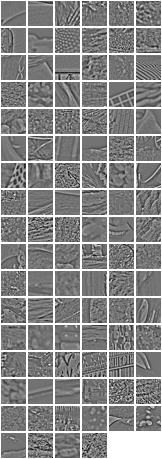

In [10]:
filename = paths.basename(params.datafile)
if not paths.filep(filename) then
   os.execute('wget ' .. params.datafile)
end
dataset = getdata(filename, params.inputsize)

if params.display then
   displayData(dataset, 100, 10, 2)
end

In [11]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 2: TRAINING
-- 
-- 
-- 
----------------------------------------------------------------------

In [12]:
-----------------------------------------------------------------------
print '==> constructing model'

if params.model == 'linear' then

   -- params
   inputSize = params.inputsize*params.inputsize
   outputSize = params.nfiltersout

   -- encoder
   encoder = nn.Sequential()
   encoder:add(nn.Linear(inputSize,outputSize))
   encoder:add(nn.Tanh())
   encoder:add(nn.Diag(outputSize))

   -- decoder
   decoder = nn.Sequential()
   decoder:add(nn.Linear(outputSize,inputSize))

   -- tied weights
   if params.tied and not params.hessian then
      -- impose weight sharing
      decoder:get(1).weight = encoder:get(1).weight:t()
      decoder:get(1).gradWeight = encoder:get(1).gradWeight:t()
   elseif params.tied then
      print('==> WARNING: weight sharing only supported with no hessian computation')
   end

   -- complete model
   module = unsup.AutoEncoder(encoder, decoder, params.beta)

   -- verbose
   print('==> constructed linear auto-encoder')

elseif params.model == 'conv' then

   -- params:
   conntable = nn.tables.full(params.nfiltersin, params.nfiltersout)
   kw, kh = params.kernelsize, params.kernelsize
   iw, ih = params.inputsize, params.inputsize

   -- connection table:
   local decodertable = conntable:clone()
   decodertable[{ {},1 }] = conntable[{ {},2 }]
   decodertable[{ {},2 }] = conntable[{ {},1 }]
   local outputFeatures = conntable[{ {},2 }]:max()

   -- encoder:
   encoder = nn.Sequential()
   encoder:add(nn.SpatialConvolutionMap(conntable, kw, kh, 1, 1))
   encoder:add(nn.Tanh())
   encoder:add(nn.Diag(outputFeatures))

   -- decoder:
   decoder = nn.Sequential()
   decoder:add(nn.SpatialFullConvolutionMap(decodertable, kw, kh, 1, 1))

   -- complete model
   module = unsup.AutoEncoder(encoder, decoder, params.beta)

   -- convert dataset to convolutional (returns 1xKxK tensors (3D), instead of K*K (1D))
   dataset:conv()

   -- verbose
   print('==> constructed convolutional auto-encoder')

elseif params.model == 'linear-psd' then

   -- params
   inputSize = params.inputsize*params.inputsize
   outputSize = params.nfiltersout

   -- encoder
   encoder = nn.Sequential()
   encoder:add(nn.Linear(inputSize,outputSize))
   encoder:add(nn.Tanh())
   encoder:add(nn.Diag(outputSize))

   -- decoder is L1 solution
   decoder = unsup.LinearFistaL1(inputSize, outputSize, params.lambda)

   -- PSD autoencoder
   module = unsup.PSD(encoder, decoder, params.beta)

   -- verbose
   print('==> constructed linear predictive sparse decomposition (PSD) auto-encoder')

elseif params.model == 'conv-psd' then

   -- params:
   conntable = nn.tables.full(params.nfiltersin, params.nfiltersout)
   kw, kh = params.kernelsize, params.kernelsize
   iw, ih = params.inputsize, params.inputsize

   -- connection table:
   local decodertable = conntable:clone()
   decodertable[{ {},1 }] = conntable[{ {},2 }]
   decodertable[{ {},2 }] = conntable[{ {},1 }]
   local outputFeatures = conntable[{ {},2 }]:max()

   -- encoder:
   encoder = nn.Sequential()
   encoder:add(nn.SpatialConvolutionMap(conntable, kw, kh, 1, 1))
   encoder:add(nn.Tanh())
   encoder:add(nn.Diag(outputFeatures))

   -- decoder is L1 solution:
   decoder = unsup.SpatialConvFistaL1(decodertable, kw, kh, iw, ih, params.lambda)

   -- PSD autoencoder
   module = unsup.PSD(encoder, decoder, params.beta)

   -- convert dataset to convolutional (returns 1xKxK tensors (3D), instead of K*K (1D))
   dataset:conv()

   -- verbose
   print('==> constructed convolutional predictive sparse decomposition (PSD) auto-encoder')

else
   print('==> unknown model: ' .. params.model)
   os.exit()
end

==> constructing model	


In [13]:
----------------------------------------------------------------------
-- 
-- 
-- 
-- STEP 3: SECOND-ORDER INFORMATION
-- 
-- 
-- 
----------------------------------------------------------------------

==> constructed convolutional predictive sparse decomposition (PSD) auto-encoder	


In [14]:
-- fix needed to avoid error: attempt to call method 'initDiagHessianParameters' (a nil value)
-- fix from: https://github.com/torch/tutorials/issues/4
nn.hessian.enable()

==> training model	


==> estimating diagonal hessian elements	


==> ddl/ddx : min/max = 0/625	
==> corrected ddl/ddx : min/max = 0.02/500	


Progress: 12 / 5000	


Progress: 124 / 5000	


Progress: 223 / 5000	


Progress: 319 / 5000	


Progress: 420 / 5000	


Progress: 523 / 5000	


Progress: 622 / 5000	


Progress: 742 / 5000	


Progress: 901 / 5000	


Progress: 1048 / 5000	


Progress: 1209 / 5000	


Progress: 1375 / 5000	


Progress: 1550 / 5000	


Progress: 1698 / 5000	


Progress: 1864 / 5000	


Progress: 2032 / 5000	


Progress: 2208 / 5000	


Progress: 2373 / 5000	


Progress: 2539 / 5000	


Progress: 2707 / 5000	


Progress: 2867 / 5000	


Progress: 3029 / 5000	


Progress: 3195 / 5000	


Progress: 3351 / 5000	


Progress: 3505 / 5000	


Progress: 3668 / 5000	


Progress: 3829 / 5000	


Progress: 3992 / 5000	


Progress: 4115 / 5000	


Progress: 4206 / 5000	


Progress: 4307 / 5000	


Progress: 4442 / 5000	


Progress: 4540 / 5000	


Progress: 4645 / 5000	


Progress: 4747 / 5000	


Progress: 4911 / 5000	


==> iteration = 5000, average loss = 33.334388070442	


Decoder filters	


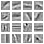

Encoder filters	


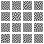

Progress: 69 / 5000	


Progress: 223 / 5000	


Progress: 375 / 5000	


Progress: 530 / 5000	


Progress: 693 / 5000	


Progress: 851 / 5000	


Progress: 1008 / 5000	


Progress: 1165 / 5000	


Progress: 1321 / 5000	


Progress: 1490 / 5000	


Progress: 1650 / 5000	


Progress: 1817 / 5000	


Progress: 1970 / 5000	


Progress: 2131 / 5000	


Progress: 2282 / 5000	


Progress: 2435 / 5000	


Progress: 2589 / 5000	


Progress: 2750 / 5000	


Progress: 2914 / 5000	


Progress: 3073 / 5000	


Progress: 3231 / 5000	


Progress: 3370 / 5000	


Progress: 3534 / 5000	


Progress: 3696 / 5000	


Progress: 3860 / 5000	


Progress: 4013 / 5000	


Progress: 4135 / 5000	


Progress: 4230 / 5000	


Progress: 4327 / 5000	


Progress: 4415 / 5000	


Progress: 4506 / 5000	


Progress: 4597 / 5000	


Progress: 4702 / 5000	


Progress: 4799 / 5000	


Progress: 4890 / 5000	


Progress: 4990 / 5000	


==> iteration = 10000, average loss = 20.74220627084	
Decoder filters	


Encoder filters	


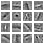

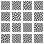

==> estimating diagonal hessian elements	


In [ ]:

-----------------------------------------------------------------------
print '==> training model'

-- are we using the hessian?
if params.hessian then
   module:initDiagHessianParameters()
end

-- get all parameters
x,dl_dx,ddl_ddx = module:getParameters()

-- training errors
local err = 0
local iter = 0

for t = 1,params.maxiter,params.batchsize do

   --------------------------------------------------------------------
   -- update diagonal hessian parameters
   --
   if params.hessian and math.fmod(t , params.hessianinterval) == 1 then
      -- some extra vars:
      local hessiansamples = params.hessiansamples
      local minhessian = params.minhessian
      local maxhessian = params.maxhessian
      local ddl_ddx_avg = ddl_ddx:clone(ddl_ddx):zero()
      etas = etas or ddl_ddx:clone()

      print('==> estimating diagonal hessian elements')
      for i = 1,hessiansamples do
         -- next
         local ex = dataset[i]
         local input = ex[1]
         local target = ex[2]
         module:updateOutput(input, target)

         -- gradient
         dl_dx:zero()
         module:updateGradInput(input, target)
         module:accGradParameters(input, target)

         -- hessian
         ddl_ddx:zero()
         module:updateDiagHessianInput(input, target)
         module:accDiagHessianParameters(input, target)

         -- accumulate
         ddl_ddx_avg:add(1/hessiansamples, ddl_ddx)
      end

      -- cap hessian params
      print('==> ddl/ddx : min/max = ' .. ddl_ddx_avg:min() .. '/' .. ddl_ddx_avg:max())
      ddl_ddx_avg[torch.lt(ddl_ddx_avg,minhessian)] = minhessian
      ddl_ddx_avg[torch.gt(ddl_ddx_avg,maxhessian)] = maxhessian
      print('==> corrected ddl/ddx : min/max = ' .. ddl_ddx_avg:min() .. '/' .. ddl_ddx_avg:max())

      -- generate learning rates
      etas:fill(1):cdiv(ddl_ddx_avg)
   end

   --------------------------------------------------------------------
   -- progress
   --
   iter = iter+1
   xlua.progress(iter*params.batchsize, params.statinterval)

   --------------------------------------------------------------------
   -- create mini-batch
   --
   local example = dataset[t]
   local inputs = {}
   local targets = {}
   for i = t,t+params.batchsize-1 do
      -- load new sample
      local sample = dataset[i]
      local input = sample[1]:clone()
      local target = sample[2]:clone()
      table.insert(inputs, input)
      table.insert(targets, target)
   end

   --------------------------------------------------------------------
   -- define eval closure
   --
   local feval = function()
      -- reset gradient/f
      local f = 0
      dl_dx:zero()

      -- estimate f and gradients, for minibatch
      for i = 1,#inputs do
         -- f
         f = f + module:updateOutput(inputs[i], targets[i])

         -- gradients
         module:updateGradInput(inputs[i], targets[i])
         module:accGradParameters(inputs[i], targets[i])
      end

      -- normalize
      dl_dx:div(#inputs)
      f = f/#inputs

      -- return f and df/dx
      return f,dl_dx
   end

   --------------------------------------------------------------------
   -- one SGD step
   --
   sgdconf = sgdconf or {learningRate = params.eta,
                         learningRateDecay = params.etadecay,
                         learningRates = etas,
                         momentum = params.momentum}
   _,fs = optim.sgd(feval, x, sgdconf)
   err = err + fs[1]*params.batchsize -- so that err is indep of batch size

   -- normalize
   if params.model:find('psd') then
      module:normalize()
   end

   --------------------------------------------------------------------
   -- compute statistics / report error
   --
   if iter*params.batchsize >= params.statinterval then

      -- report
      print('==> iteration = ' .. t .. ', average loss = ' .. err/params.statinterval)

      -- get weights
      eweight = module.encoder.modules[1].weight
      if module.decoder.D then
         dweight = module.decoder.D.weight
      else
         dweight = module.decoder.modules[1].weight
      end

      -- reshape weights if linear matrix is used
      if params.model:find('linear') then
         dweight = dweight:transpose(1,2):unfold(2,params.inputsize,params.inputsize)
         eweight = eweight:unfold(2,params.inputsize,params.inputsize)
      end

      -- render filters
      dd = image.toDisplayTensor{input=dweight,
                                 padding=2,
                                 nrow=math.floor(math.sqrt(params.nfiltersout)),
                                 symmetric=true}
      de = image.toDisplayTensor{input=eweight,
                                 padding=2,
                                 nrow=math.floor(math.sqrt(params.nfiltersout)),
                                 symmetric=true}

      -- live display
      if params.display then
         if itorch then
            print('Decoder filters')
            itorch.image(dd)
            print('Encoder filters')
            itorch.image(de)
         else
            print('run in itorch for visualization')
         end
      end

      -- save stuff
      image.save(params.rundir .. '/filters_dec_' .. t .. '.jpg', dd)
      image.save(params.rundir .. '/filters_enc_' .. t .. '.jpg', de)
      torch.save(params.rundir .. '/model_' .. t .. '.bin', module)

      -- reset counters
      err = 0; iter = 0
   end
end